In [77]:
import sys
sys.path.append('../')
# import adaprobe
import holoprobe
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [78]:
fontsize=12

In [79]:
# from importlib import reload
# reload(holoprobe.simulation)

In [108]:
N = 9 # number of cells
sigma = 3 # noise variance
spacing = 10 # minimum distance between cells
a = 0.75 # connection probability
sim = holoprobe.Simulation3d(N=N, sigma=sigma, spacing=spacing, a=a, mode='offline', filter_dim_len=20, dimx=100, dimy=100, dimz=100)

In [109]:
xs, ys, zs = sim.cell_locs[:, 0], sim.cell_locs[:, 1], sim.cell_locs[:, 2]

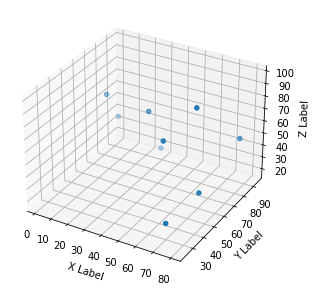

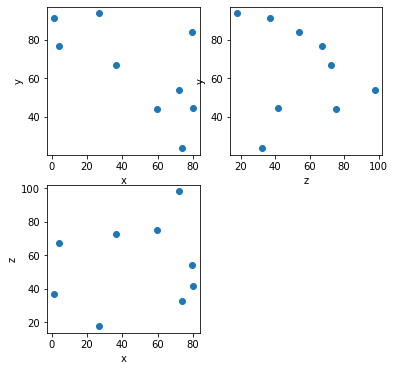

In [110]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.scatter(xs, ys)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2, 2, 2)
plt.scatter(zs, ys)
plt.xlabel('z')
plt.ylabel('y')

plt.subplot(2, 2, 3)
plt.scatter(xs, zs)
plt.xlabel('x')
plt.ylabel('z')

plt.show()

In [111]:
K = 1000 # number of trials
powers = np.arange(10, 51, 10) # available laser powers
sim.simulate(trials=K, powers=powers)

In [112]:
spks = np.array(sim.spks).T
y = sim.y

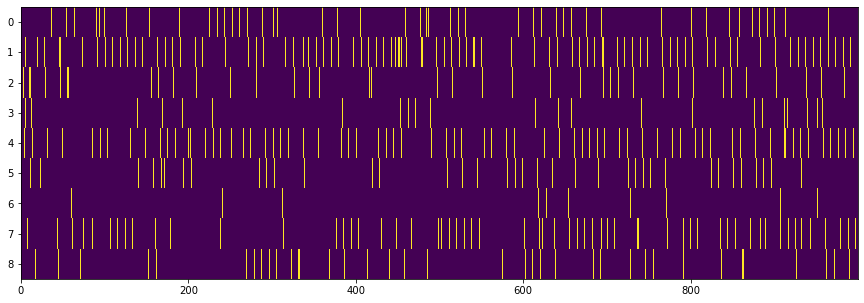

In [113]:
plt.figure(figsize=(15, 5))
plt.imshow(spks, aspect='auto', interpolation='nearest')
plt.show()

In [136]:
priors = {
    'alpha': 0.5 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 2e1 * np.ones(N),
    'shape': 1,
    'rate': 1
#     'eta': sim.cell_filters
}

# priors = {
#     'alpha': np.ones(N),
#     'mu': sim.w,
#     'beta': 1e-1 * np.ones(N),
#     'shape': 1,
#     'rate': 1
# }

fit_options = {
    'iters': 50,
    'num_mc_samples': 10,
    'lam_update': 'monte-carlo',
    'a_rel': 5,
    'b_rel': 1e1
}

# MAP is good w/ true filts

model = holoprobe.Model(sim.cell_locs, priors=priors)

In [137]:
model.fit(sim.y, (sim.L, sim.I), fit_options=fit_options)

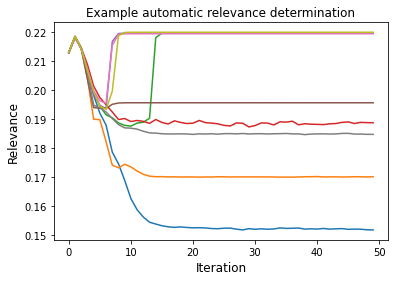

In [168]:
plt.plot(model.history['rel'])
plt.ylabel('Relevance', fontsize=fontsize)
plt.xlabel('Iteration', fontsize=fontsize)
plt.title('Example automatic relevance determination', fontsize=fontsize)
# plt.savefig('figs/example_ARD.png', format='png', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

In [139]:
lam = np.array(model.state['lam']).T

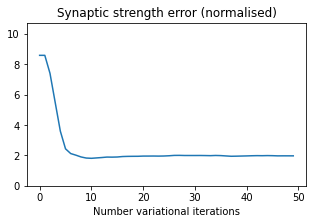

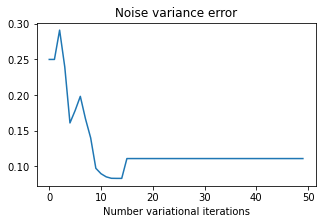

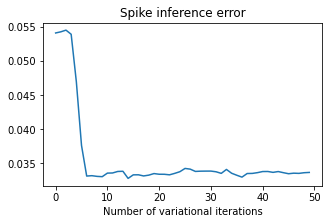

In [140]:
def plot_hist(model, sim):
    err = np.mean(np.abs(model.history['mu'] - sim.w), 1)
    plt.figure(figsize=(5, 3))
    plt.plot(err)
    plt.ylim([0, 1.25 * np.max(err)])
    plt.title('Synaptic strength error (normalised)')
    plt.xlabel('Number variational iterations')
    plt.show()
    
    plt.figure(figsize=(5, 3))
    plt.plot(np.mean(np.square(model.history['alpha'] - sim.z), 1))
    plt.title('Noise variance error')
    plt.xlabel('Number variational iterations')
    plt.show()
    
    spks = np.array(sim.spks).T
    spk_errs = np.array([np.mean(np.abs(model.history['lam'][:, n] - spks[n]), -1) for n in range(sim.N)])
    
    plt.figure(figsize=(5, 3))
    plt.plot(np.mean(spk_errs, 0), color='C0')
    plt.title('Spike inference error')
    plt.xlabel('Number of variational iterations')
    plt.show()
    
plot_hist(model, sim)

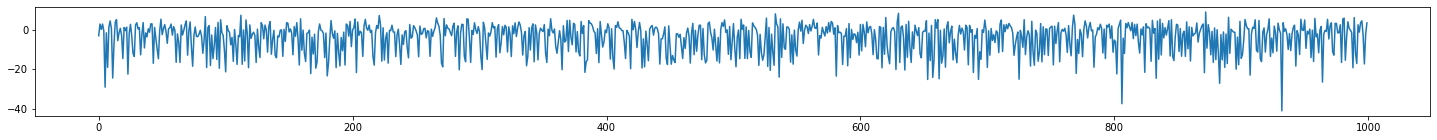

In [141]:
plt.figure(figsize=(25, 2))
plt.plot(sim.y[:1000])

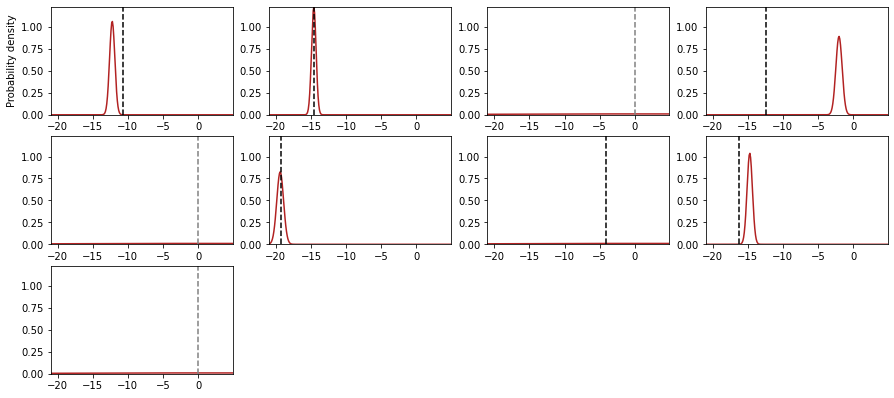

In [142]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, sim, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(model, sim)

In [143]:
1/np.sqrt(model.state['shape']/model.state['rate'])

3.240807535293298

In [144]:
print(model.state['alpha'])

[1.         1.         0.49999979 0.99993744 0.49999981 1.
 0.49999981 1.         0.49999979]


In [145]:
print(np.round(model.state['mu'], 2))
print(np.round(sim.w, 2))

[-12.23 -14.61  -0.    -2.01   0.   -19.4   -0.   -14.72   0.  ]
[-10.7  -14.55  -0.   -12.46  -0.   -19.28  -4.05 -16.26  -0.  ]


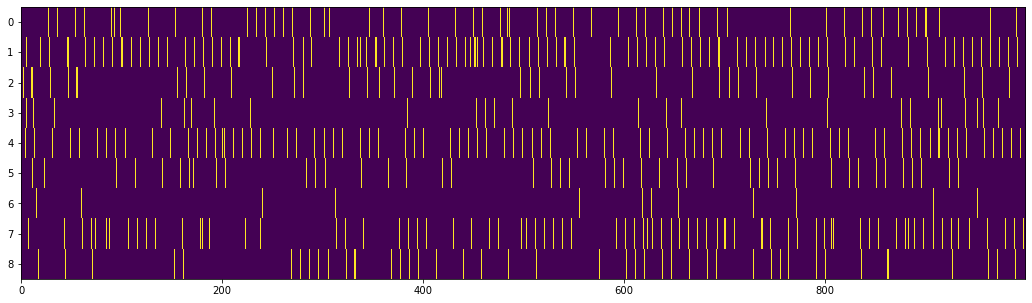

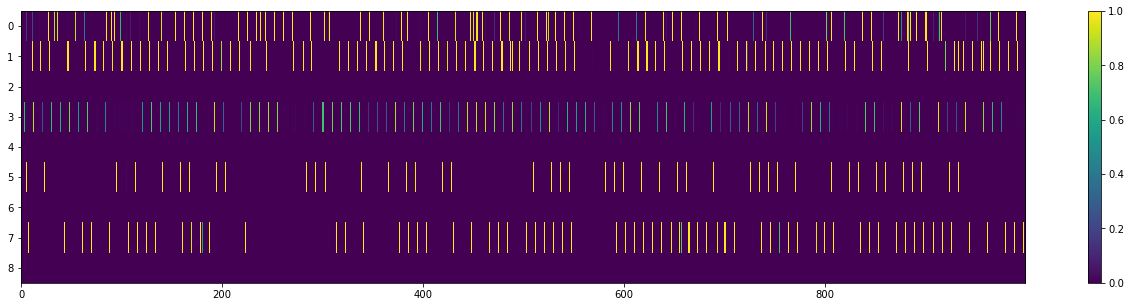

In [146]:
plt.figure(figsize=(18, 5))
plt.imshow(spks[:,:1000], aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(22.5, 5))
plt.imshow(lam[:, :1000], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.show()

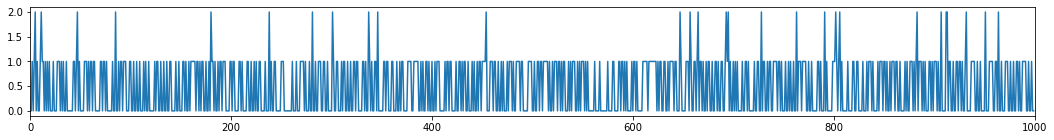

In [147]:
spks = np.array(sim.spks).T
plt.figure(figsize=(18, 2))
plt.plot(np.sum(spks, 0)[:1000])
plt.xlim([0, 1000])
plt.show()

[Text(0.5, 0, '0'), Text(1.5, 0, '1'), Text(2.5, 0, '2'), Text(3.5, 0, '3')]

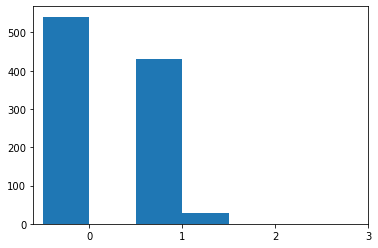

In [148]:
plt.hist(np.sum(spks, 0), 4)
plt.xticks(np.arange(4)+0.5)
plt.gca().set_xticklabels(np.arange(4))

In [149]:
def plot_spike_pred(model, sim, xlim=None):
    spks = np.array(sim.spks).T.astype(float) # true simulated spikes
    fr = np.array(sim.fr).T # true simulated firing rates
    lam = np.array(model.state['lam']).T # inferred firing rate
    s_pred = (lam >= 0.5).astype(float) # spike prediction
    for n in range(N):
        plt.figure(figsize=(25, 0.75))
        if sim.w[n] == 0:
            plt.plot(fr[n], color='gray') # disconnected cell
            plt.scatter(np.arange(len(spks[n])), spks[n], color='gray')
        else:
            plt.plot(fr[n], color='k') # connected cell
            plt.scatter(np.arange(len(spks[n])), spks[n], color='k')
        plt.plot(lam[n], '--', color='r')
        plt.scatter(np.arange(s_pred[0].shape[0]), s_pred[n], 50, marker='x', color='r')
        if xlim is not None:
            plt.xlim(xlim)
        else:
            plt.xlim([0, lam.shape[-1]])
        plt.ylim([0, 1.1])
        plt.show()

In [150]:
fr = np.array(sim.fr).T

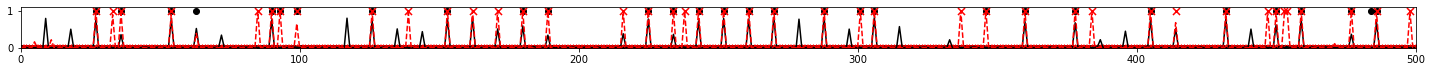

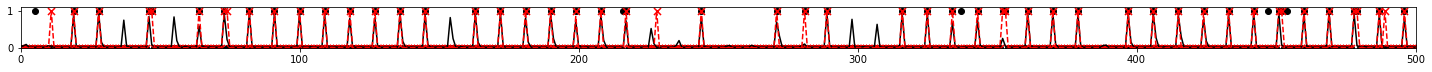

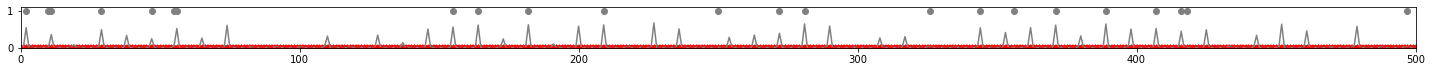

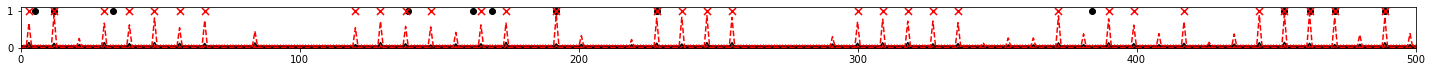

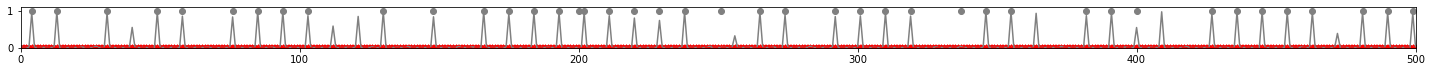

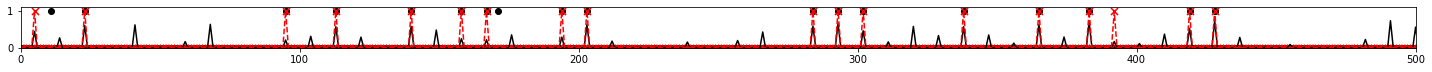

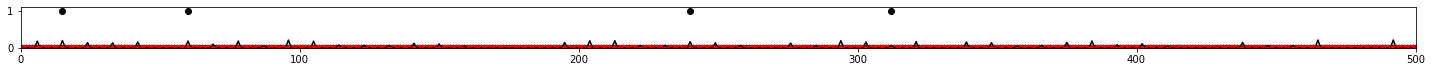

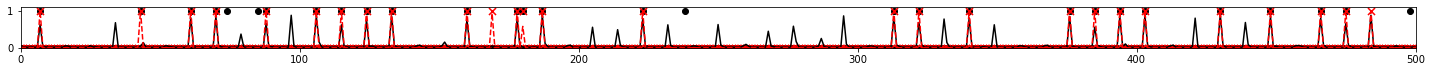

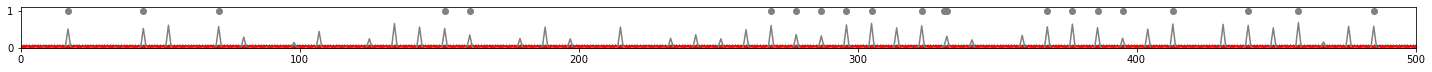

In [151]:
plot_spike_pred(model, sim, xlim=[0, 500])

In [158]:
model.cell_locs

array([[79.67242762, 44.39142783, 41.891214  ],
       [ 1.4772196 , 91.466615  , 37.01213504],
       [ 4.14257393, 76.99971796, 67.00291686],
       [36.49576901, 66.8546575 , 72.45155696],
       [73.84617312, 23.60926738, 32.51168259],
       [26.90251198, 93.7662055 , 17.84246227],
       [79.59161488, 84.30147341, 54.11587341],
       [59.55871994, 43.81745549, 75.14140791],
       [72.01791107, 53.87812537, 98.04827271]])

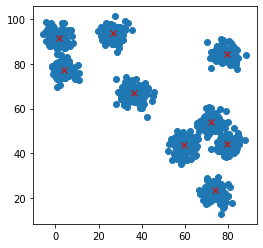

In [161]:
plt.figure(figsize=(4, 4))
plt.scatter(sim.L[:, 0], sim.L[:, 1])
plt.scatter(model.cell_locs[:, 0], model.cell_locs[:, 1], marker='x', color='firebrick')
plt.show()
# plt.xlim([0, 120])
# plt.ylim([0, 120])

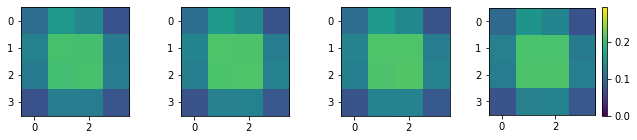

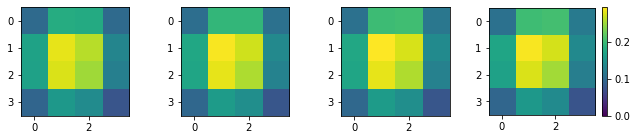

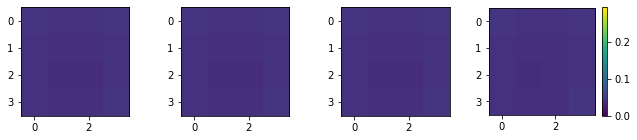

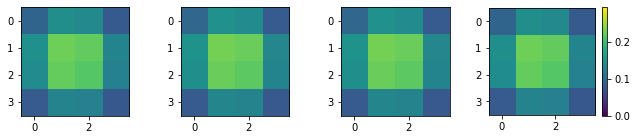

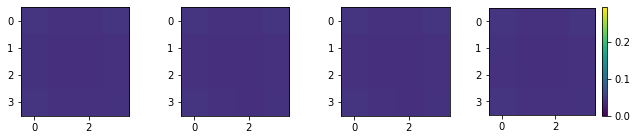

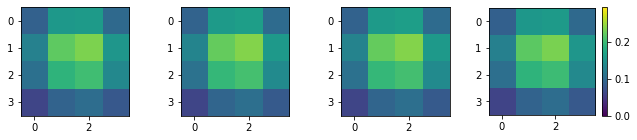

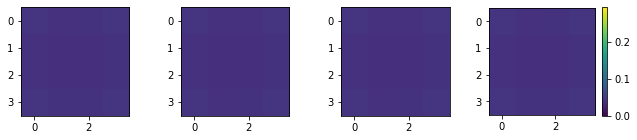

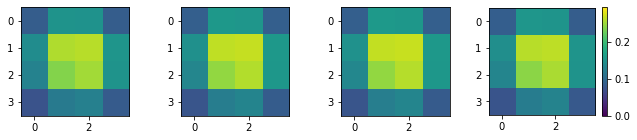

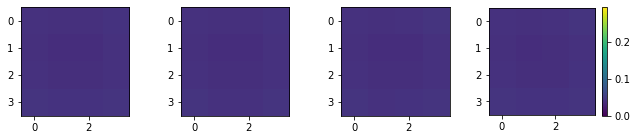

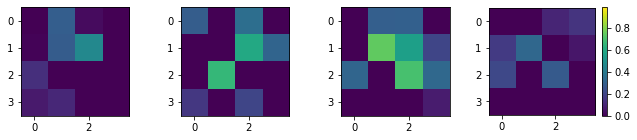

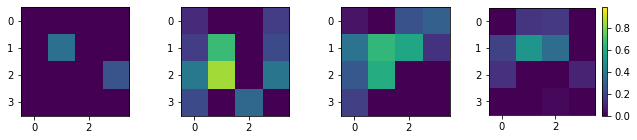

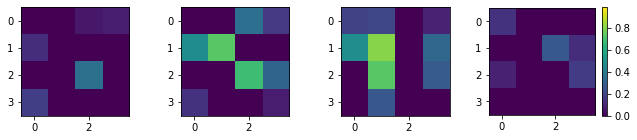

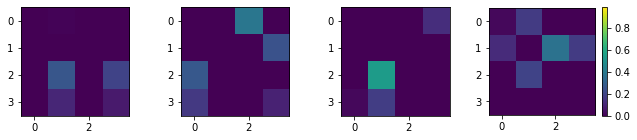

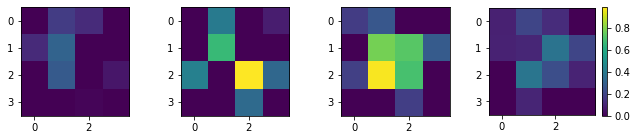

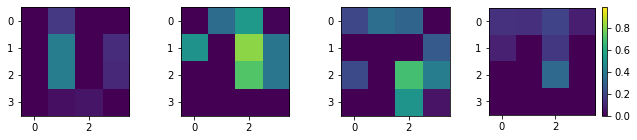

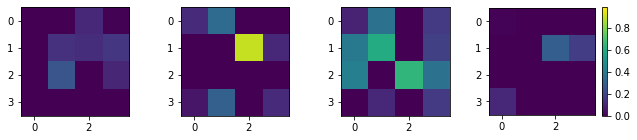

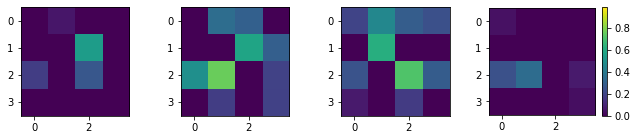

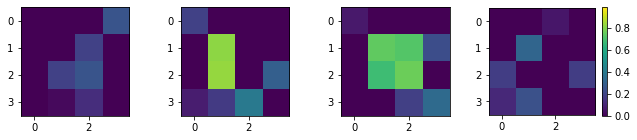

In [162]:
panel_width = 2
vmax_sim = np.max(sim.cell_filters[:, :-1])
vmax_mod = np.max(model.state['eta'][:, :-1])

for n in range(N):
    plt.figure(figsize=(4*panel_width + 3, panel_width))
    for d in range(4):
        plt.subplot(1, 4, d+1)
        plt.imshow(model.state['eta'][n][:-1].reshape([4, 4, 4])[..., d], vmin=0, vmax=vmax_mod)
    plt.colorbar()
    plt.show()
    
panel_width = 2
for n in range(N):
    plt.figure(figsize=(4*panel_width + 3, panel_width))
    for d in range(4):
        plt.subplot(1, 4, d+1)
        plt.imshow(sim.cell_filters[n][:-1].reshape([4, 4, 4])[..., d], vmin=0, vmax=vmax_sim)
    plt.colorbar()
    plt.show()

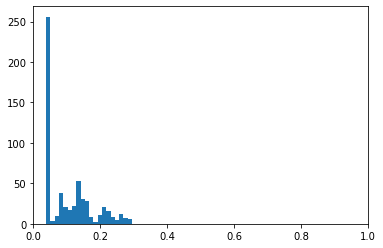

In [163]:
plt.hist(model.state['eta'][:, :-1].flatten(), 20)
plt.xlim([0, 1])
plt.show()

(0.0, 1.0)

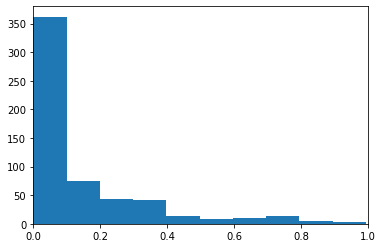

In [164]:
plt.hist(sim.cell_filters[:, :-1].flatten())
plt.xlim([0, 1])

In [165]:
eta_cov = model.state['eta_cov']

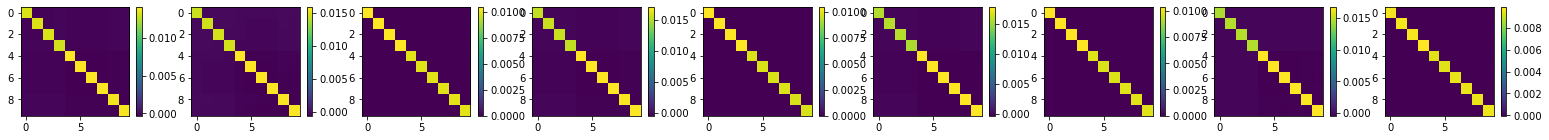

In [166]:

plt.figure(figsize=(N*3, 2))
for n in range(N):
    plt.subplot(1, N, n+1)
    plt.imshow(model.state['eta_cov'][n][:10, :10])
    plt.colorbar()
plt.show()